# MRNet Image Classifier for the MSL Dataset
This is a model to classify images from the Right Mastcam on the Curiosity rover.

There are three parts:
1. Prepare Hardware and Data
2. Building and Training
3. Evaluation and Predictions

-Riley Knybel 7/16/2023

## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "mr-images"

2023-07-26 23:26:09.743158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 23:26:10.371293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-07-26 23:26:13.944608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:26:13.950269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:26:13.950430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
#count the images in the dataset
count = 0
cpt = sum([len(files) for r, d, files in os.walk(img_folder)])
print(str(cpt) + " total images in dataset")

2402 total images in dataset


In [4]:
#load the dataset using Keras

#SPLIT
#Train/Validate/Test
#70%/15%/15%

batch_size = 4
img_height = 227
img_width = 227

#training/validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_folder,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_and_test = tf.keras.utils.image_dataset_from_directory(
  img_folder,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds, test_ds = tf.keras.utils.split_dataset(val_and_test, left_size=0.5)

val_size = len(val_ds) * batch_size
test_size = len(test_ds) * batch_size

print("True validation size: " + str(val_size))
print("True test size: " + str(test_size))

Found 2402 files belonging to 15 classes.
Using 1682 files for training.
Found 2402 files belonging to 15 classes.
Using 720 files for validation.


2023-07-26 23:26:17.200986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:26:17.201240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:26:17.201350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True validation size: 360
True test size: 360


In [5]:
# show class names
class_names = train_ds.class_names
print(class_names)

['apxs', 'chemcam cal target', 'drill\n', 'drt front', 'drt side', 'ground', 'horizon', 'mahli', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rover rear deck', 'scoop']


In [6]:
#normalize data - change pixel scale from 0-255 to 0-1
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


## Part 2/3: Building and Training

In [7]:
#alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='softmax')
])

In [8]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [10]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)


In [11]:
#train the model, time to cook!

#repeat is used to make sure there is enough training data for 3000 iterations

epochs=6
steps_per_epoch=500
history = model.fit(
  train_ds.repeat(9),
  validation_data=val_ds.repeat(9),
  epochs=epochs,
  steps_per_epoch=steps_per_epoch
)

Epoch 1/6


/home/riley/.local/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-26 23:26:41.080709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-26 23:26:41.275197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 23:26:41.284074: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561f53046820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 23:26:41.284113: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-26 23:26:41.287705: I ten

500/500 [==============================] - 20s 31ms/step - loss: 3.0470 - accuracy: 0.7012 - val_loss: 5.0288 - val_accuracy: 0.7333
Epoch 2/6
500/500 [==============================] - 15s 30ms/step - loss: 1.6852 - accuracy: 0.7968 - val_loss: 5.0777 - val_accuracy: 0.7389
Epoch 3/6
500/500 [==============================] - 15s 30ms/step - loss: 0.9954 - accuracy: 0.8654 - val_loss: 1.3101 - val_accuracy: 0.8389
Epoch 4/6
500/500 [==============================] - 15s 30ms/step - loss: 0.7276 - accuracy: 0.8899 - val_loss: 0.5715 - val_accuracy: 0.9111
Epoch 5/6
500/500 [==============================] - 15s 30ms/step - loss: 0.5973 - accuracy: 0.9104 - val_loss: 0.4519 - val_accuracy: 0.9083
Epoch 6/6
500/500 [==============================] - 15s 30ms/step - loss: 0.7459 - accuracy: 0.9043 - val_loss: 1.1032 - val_accuracy: 0.9194


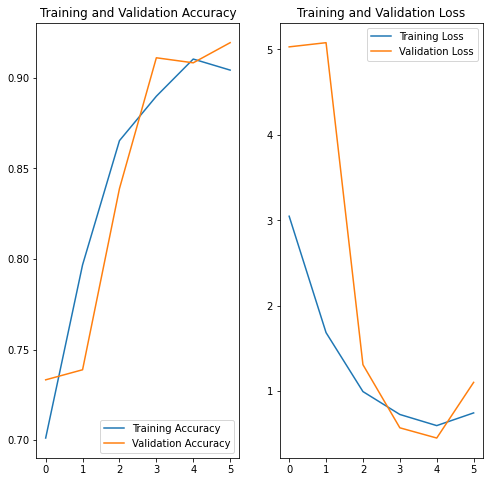

In [12]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [13]:
#evaluate the accuracy
score = model.evaluate(val_ds, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

score = model.evaluate(test_ds, verbose=0)
print("Test Loss: " + str(score[0]))
print("Test Accuracy: " + str(score[1]))

Validation Loss: 1.1032503843307495
Validation Accuracy: 0.9194444417953491
Test Loss: 1.5139305591583252
Test Accuracy: 0.8833333253860474
